In [281]:
import numpy as np
from easyvec import Vec3, Mat3
from interpolation import Interp1d, Interp2d
from math import *
from aero_info import *

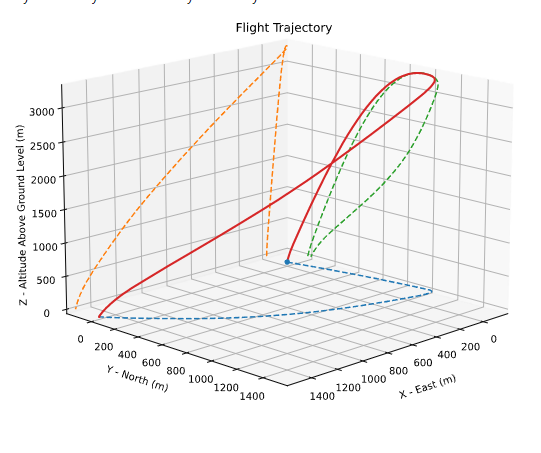

In [443]:
opts = {
    'd': 0.230,
    'L': 2.89,
    'm_0': 165,
    'v_0': 25,
    't_marsh': 6,
    'w_marsh': 53,
    'P_marsh': 22.5*1e3,
    'alpha_max': 20,
    'xi': 0.5,
    'a_m': 5,
    'record': False
}

In [486]:
class Missile3D(object):
    
    @classmethod
    def get_missile(cls, opts):
        """
        Классовый метод создания ракеты со всеми необходимыми аэродинамическими, массо- и тяговременными характеристиками
        
        Arguments
        ---------
        opts : dict 
               словарь с параметрами ракеты
               
        Returns
        -------
        missile : cls
                  экземпляр класса Missile3D
        """
        @np.vectorize
        def get_m(t):
            if t < t_marsh:
                return m_0 - G_marsh * t
            else:
                return m_0 - w_marsh
            
        @np.vectorize
        def get_P(t):
            if t < t_marsh:
                return P_marsh
            else:
                return 0
                
        d = opts['d']
        L = opts['L']
        m_0 = opts['m_0']
        v_0 = opts['v_0']
        alpha_max = opts['alpha_max']
        xi = opts.get('xi', 0.5)
        t_marsh = opts['t_marsh']
        w_marsh = opts['w_marsh']
        P_marsh = opts['P_marsh']
        G_marsh = w_marsh / t_marsh
        am = opts.get('am', 4.5)
        dny = opts.get('dny', 1)
        dnz = opts.get('dnz', 1)
        vel_wind = opts.get('vel_wind', [0,0,0])
        postProcessing = opts.get('record', True)
        
        df1 = pd.read_csv('data_constants/cya_from_mach.csv', sep = ";")
        df2 = pd.read_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
        arr_alpha = np.array(df2.index)
        arr_mach = df1['Mach']
        arr_cx = df2.to_numpy()
        Cx_itr = Interp2d(arr_alpha, arr_mach, arr_cx)
        
        arr_alpha = np.array([-10, -7, -5, -3, -1, 0, 1, 3, 5, 7, 10])
        arr_mach = np.array([0.3, 0.6, 0.9, 1, 1.1, 1.4, 1.7, 2.0, 2.3])
        arr_cy_alpha = np.array([0.2, 0.3, 0.35, 0.4, 0.35, 0.3, 0.25, 0.225, 0.2])
        arr_cy_delta = np.array([0.15, 0.25, 0.30, 0.35, 0.30, 0.25, 0.20, 0.175, 0.15])
        
        ts    = np.linspace(0, t_marsh, 100)
        m_itr = Interp1d(ts, get_m(ts))
        P_itr = Interp1d(ts, get_P(ts))
        atm_itr = table_atm
        Cy_alpha_itr = Interp1d(arr_mach, arr_cy_alpha)
        Cy_delta_itr = Interp1d(arr_mach, arr_cy_delta)
        
        missile = cls(d=d, m_0=m_0, L=L, v_0=v_0, P_itr=P_itr, m_itr=m_itr, t_marsh=t_marsh, w_marsh=w_marsh, G_marsh=G_marsh,
                      Cx_itr=Cx_itr, Cy_alpha_itr=Cy_alpha_itr, Cy_delta_itr=Cy_delta_itr, atm_itr=atm_itr, vel_wind=vel_wind,
                      alpha_max=alpha_max, xi=xi, am=am, dny=dny, dnz=dnz,
                      postProcessing=postProcessing)
        
        return missile
    
    def __init__(self, qw=1, qx=0, qy=0, qz=0, g=9.80665, n=16, **kwargs):
        """
        Конструктор класса Missile3D
        
        Arguments
        ---------
        
        ...
        
        """
        self.g = g
        self.t = 0
        self.n = n
        self.state = np.zeros(self.n)
        self.state_init = np.zeros(self.n)
                
        self.d       = kwargs['d']
        self.L       = kwargs['L']
        self.m_0     = kwargs['m_0']
        self.S_mid   = np.pi * self.d**2 / 4
        self.v       = kwargs['v_0']
        self.v_0     = kwargs['v_0']
        self.xi      = kwargs['xi']
        self.t_marsh = kwargs['t_marsh']
        self.w_marsh = kwargs['w_marsh']
        self.G_marsh = kwargs['G_marsh']
        self.alpha_max = kwargs['alpha_max']
        self.alpha_targeting = 0
        self.P_itr   = kwargs['P_itr']
        self.m_itr   = kwargs['m_itr']
        self.Cx_itr  = kwargs['Cx_itr']
        self.Cy_alpha_itr = kwargs['Cy_alpha_itr']
        self.Cy_delta_itr = kwargs['Cy_delta_itr']
        self.xi = kwargs['xi']
        self.atm_itr = kwargs['atm_itr']
        self.vel_wind = kwargs['vel_wind']
        self.am = kwargs['am']
        self.dny = kwargs['dny']
        self.dnz = kwargs['dnz']
        self.postProcessing = kwargs['postProcessing']
        
        self.Fx = []
        self.Fy = []
        self.Fz = []
        self.Mx = []
        self.My = []
        self.Mz = []
        self.angle = []
        
        # Инициилизация кватерниона 
        if ("scalar" in kwargs) or ("vector" in kwargs):
            # с помощью скалярной и векторной части
            scalar = kwargs.get("scalar", 0.0)
            if scalar is None:
                scalar = 0.0
            else:
                scalar = float(scalar)
            vector = kwargs.get("vector", [])
            vector = self._validate_number_sequence(vector, 3)
            self.qw = scalar
            self.qx, self.qy, self.qz = vector
        elif ("thetta" in kwargs) or ("psi" in kwargs) or ("gamma" in kwargs):
            # с помощью самолетных углов
            thetta = np.radians(kwargs.get("thetta", 0.0))
            psi = np.radians(kwargs.get("psi", 0.0))
            gamma = np.radians(kwargs.get("gamma", 0.0))
            self.qw = np.cos(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
            self.qx = np.cos(thetta/2) * np.cos(psi/2) * np.sin(gamma/2) - np.sin(thetta/2) * np.sin(psi/2) * np.cos(gamma/2)
            self.qy = np.cos(thetta/2) * np.sin(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.cos(psi/2) * np.sin(gamma/2)
            self.qz = np.sin(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) - np.cos(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        elif "array" in kwargs:
            self.qw, self.qx, self.qy, self.qz = self._validate_number_sequence(kwargs["array"], 4)
        else:
            # по умолчанию
            self.qw = qw
            self.qx = qx
            self.qy = qy
            self.qz = qz
        self._normalise_quaternion()
    
    @property
    def rho(self):
        return self.atm_itr(self.state[1], 3)
    
    @property
    def sonic_speed(self):
        return self.atm_itr(self.state[1], 4)
    
    @property
    def G(self):
        return Vec3(0.0, self.m_itr(self.t) * self.g, 0.0)
    
    @property
    def m(self):
        return self.m_itr(self.t)
    
    @property
    def P(self):
        return self.P_itr(self.t)
    
    @property
    def J(self):
        if self.t < self.t_marsh:
            Jx = 1/2 * (self.m_0 - self.G_marsh * self.t) * (self.d/2)**2
            Jy = 1/12 * (self.m_0 - self.G_marsh * self.t) * (self.L)**2
            Jz = 1/12 * (self.m_0 - self.G_marsh * self.t) * (self.L)**2
        else:
            Jx = 1/2 * (self.m_0 - self.w_marsh) * (self.d/2)**2
            Jy = 1/12 * (self.m_0 - self.w_marsh) * (self.L)**2
            Jz = 1/12 * (self.m_0 - self.w_marsh) * (self.L)**2
        return (Jx, Jy, Jz)
    
    @property
    def q_abs(self):
        """
        Текущий скоростной напор набегающего потока воздуха
        
        Returns
        -------
        q : float
        """
        return self.rho * self.vel_abs**2 / 2
    
    @property
    def mach_abs(self):
        """
        Текущее абсолютное значение числа Маха
        
        Returns
        -------
        M : float
        """
        return self.vel_abs / self.atm_itr(self.state[1], 4)
    
    @property
    def mach(self):
        """
        Текущее вектор числа Маха
        
        Returns
        -------
        M : np.ndarray
        [Mx, My, Mz]
        [0,   1,  2]
        """
        return np.array(self.vel / self.atm_itr(self.state[1], 4))
    
    @property
    def quaternion(self):
        """
        Кватернион результируюшего текущего поворота (кватернион как четырехмерный вектор)
        
        Returns
        -------
        quaternion : np.ndarray
                     q = [qw, qx, qy, qz] 
                         [ 0,  1,  2,  3]
        """
        return np.array([self.qw, self.qx, self.qy, self.qz])
    
    @property
    def norm_quaternion(self):
        """
        Свойство, возвращающее норму кватерниона (длину)
        """
        return np.sqrt(np.dot(self.quaternion, self.quaternion))

    @property
    def thetta(self):
        """
        Угол тангажа ракеты
        """
        return self.get_angle()[0]
    
    @property
    def psi(self):
        """
        Угол курса ракеты
        """
        return self.get_angle()[1]
    
    @property
    def gamma(self):
        """
        Угол крена ракеты
        """
        return self.get_angle()[2]
    
    @property
    def alpha(self):
        """
        Угол атаки корпуса ракеты в пространстве
        """
        return self.get_alpha()[0]
    
    @property
    def alpha_k(self):
        """
        Угол атаки корпуса ракеты
        """
        return self.get_alpha()[0][0]
    
    @property
    def alpha_y(self):
        """
        Угол атаки корпуса ракеты в вертикальной плоскости
        """
        return self.get_alpha()[0][1]
    
    @property
    def alpha_z(self):
        """
        Угол атаки корпуса ракеты в горизонтальной плоскости
        """
        return self.get_alpha()[0][2]
    
    @property
    def gamma_alpha(self):
        """
        Угол ориентации атаки корпуса ракеты
        """
        return self.get_alpha()[1]
    
    @property
    def pos(self):
        """
        Пространственный вектор положения ракеты в ГСК
        
        Returns
        -------
        cls Vec3
        [x, y, z] 
        [0, 1, 2]
        """
        return Vec3(self.state[0], self.state[1], self.state[2])
       
    @property
    def vel(self):
        """
        Пространственный вектор скорости ракеты
        
        Returns
        -------
        cls Vec3
        [vx, vy, vz] 
        [0,   1,  2]
        """
        return Vec3(self.state[3], self.state[4], self.state[5])
    
    @property
    def vel_abs(self):
        return np.sqrt(self.vel.dot(self.vel))
    
    @property
    def vel_stream(self):
        return self.get_vel_stream()
    
    @property
    def w(self):
        """
        Пространственный вектор углового вращения ракеты в ССК
        
        Returns
        -------
        cls Vec3
        [wx, wy, wz] 
        [0,   1,  2]
        """
        return Vec3(self.state[6], self.state[7], self.state[8])
    
#     def f_system(self, t, y):
#         """
#         Функция, записывающая правую часть системы ОДУ динамики материального тела в пространстве.
        
#         Arguments
#         ---------
#         t : float
#             Время в секундах
#         y : np.ndarray / list
#             Вектор состояния системы 
#             [0, 1, 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]
#             [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz,  t]     
            
#         Returns
#         -------
#         dy : np.ndarray / list
#              Вектор состояния после дифференцирования системы dy/dt
#              [0,   1,  2,  3,  4,  5,    6,    7,    8,   9,  10,  11,  12, 13]
#              [vx, vy, vz, ax, ay, az, epsx, epsy, epsz, dqw, dqx, dqy, dqz,  1]
#         """
#         x, y, z, vx, vy, vz, qw, qx, qy, qz, wx, wy, w3, alpha_v, alpha_h, t = y
                
#         P = self.P_itr(t)
        
#         J_x, J_y, J_z = self.J_itr(t)
                
#         vel_stream_x, vel_stream_y, vel_stream_z = self.get_vel_stream()
#         mach_x = vel_stream_x / self.sonic_speed
#         mach_y = vel_stream_y / self.sonic_speed
#         mach_z = vel_stream_z / self.sonic_speed
        
#         # Сила тяжести на ССК
#         Gx = -self.G * np.sin(self.thetta)
#         Gy = -self.G * np.cos(self.thetta)
#         Gz = -self.G * np.sin(self.gamma)
               
#         # Продольная АД сила
#         X = 1 # TODO
#         if self.vel_abs < 1e-5:
#             Xx, Xy, Xz = 0, 0, 0
#         else:
#             Xx = -X * np.cos(self.alpha_z) * np.cos(self.alpha_y)
#             Xy = -X * np.cos(self.alpha_z) * np.sin(self.alpha_y)
#             Xz = -X * np.sin(self.alpha_k) * np.sin(self.gamma_alpha)

#         # Нормальная АД сила    
#         Y = (self.Cy_alpha_itr(self.mach_abs) * self.alpha_y * self.q_abs * self.S_mid * 57.3 +\
#              self.Cy_delta_itr(self.mach_abs) * self.delta_y * self.q_abs * self.S_mid * 57.3)
#         Z = (self.Cy_alpha_itr(self.mach_abs) * self.alpha_z * self.q_abs * self.S_mid * 57.3 +\
#              self.Cy_delta_itr(self.mach_abs) * self.delta_z * self.q_abs * self.S_mid * 57.3)
        
#         # Сумма проекций всех внешних сил на ССК
#         Fx = P + Xx + Gx
#         Fy = Y + Xy + Gy
#         Fz = Z + Xz + Gz
        
#         # из ССК в ИСК
#         F_sum = self._matrix_transition() * Vec3(Fx, Fy, Fz)
#         Fx, Fy, Fz = F_sum
        
#         Mx = -self.mx_delta_itr(self.mach_abs) * self.delta_aileron * self.q_abs * self.S_mid * self.d * 57.3 -\
#                self.mx_wx_itr(self.mach_abs) * wx * self.q_abs * self.S_mid * self.d**2 * 57.3 / (2 * self.vel_abs)
#         My = # TODO
#         Mz = # TODO
        
#         dy = np.zeros(self.n)

#         # dr/dt
#         dy[0] = vx
#         dy[1] = vy
#         dy[2] = vz
        
#         # dv/dt = a
#         dy[3] = Fx / self.m_itr(t)
#         dy[4] = Fy / self.m_itr(t)
#         dy[5] = Fz / self.m_itr(t)
        
#         # domega/dt = eps
#         dy[6] = (Mx + (J_y - J_z) * wy * wz) / J_x 
#         dy[7] = (My + (J_z - J_x) * wz * wx) / J_y
#         dy[8] = (Mz + (J_x - J_y) * wx * wy) / J_z
        
#         # dq/dt
#         dy[9] = -1/2 * (qx * wx + qy * wy + qz * wz) 
#         dy[10] = 1/2 * (qw * wx - qz * wy + qy * wz)
#         dy[11] = 1/2 * (qw * wy - qx * wz + qz * wx)
#         dy[12] = 1/2 * (qw * wz - qy * wx + qx * wy)
        
#         # dalpha/dt
#         dy[13] = self.alpha_vertical_targeting - alpha_vertical
#         dy[14] = self.alpha_horizontal_targeting - alpha_horizontal
        
#         # dt/dt
#         dy[15] = 1
        
#         if self.postProcessing:
#             self.Fx.append([t, Fx])
#             self.Fy.append([t, Fy])
#             self.Fz.append([t, Fz])
#             self.Mx.append([t, Mx])
#             self.My.append([t, My])
#             self.Mz.append([t, Mz])
#             self.angle.append([t, self.get_angle()])
        
#         return dy
       
    def step(self, action, tau=0.1, n=10):
        """
        Метод моделирования динамики ракеты за шаг по времени tau
        На протяжении tau управляющее воздействие на ракету постоянно (action)
        Шаг интегирования dt определяется из числа разбиения n временного шага tau
        Функция меняет внутреннее состояние ракеты state на момент окончания шага
        
        Arguments
        ---------
        action : {tuple}
                 управляющее воздействие на протяжении шага
        tau    : {float} 
                 длина шага по времени (не путать с шагом интегрирования)
        n      : {int}
                 число шагов разбиений интервала времени tau
            
        Returns
        -------
        None
        """
        self.alpha_vertical_targeting = self.alpha_max * action[0]
        self.alpha_horizontal_targeting = self.alpha_max * action[1]
        t = self.state[-1]  
        dt = tau / n
        for i in range(n):
            k1 = self.f_system(t, self.state)
            k2 = self.f_system(t + 0.5 * dt, self._validate_y(self.state + 0.5 * dt * k1))
            k3 = self.f_system(t + 0.5 * dt, self._validate_y(self.state + 0.5 * dt * k2))
            k4 = self.f_system(t + dt,       self._validate_y(self.state + dt * k3))
            y = self._validate_y(self.state + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
            t += dt
            self.t = t
            self.state = y
            self.state[-1] = t
        
    def get_angle(self):
        """
        Метод, вычисляющий самолетные углы Крылова по текущему кватерниону поворота
        
        Returns
        -------
        np.ndarray
        [thetta, psi, gamma]
        """
        qw, qx, qy, qz = self.quaternion
        thetta = np.arctan(2*(qx*qy+qw*qz)/(2*(qw**2+qx**2)-1)) # np.arcsin(2*(qx*qz-qw*qy))
        psi = np.arcsin(2*(qw*qy-qx*qz)) # - np.arctan(2*(qx*qz-qw*qy)/(2*(qw**2+qx**2)-1))
        gamma = np.arctan(2*(qy*qz+qw*qx)/(2*(qw**2+qz**2)-1)) # - np.arctan(2*(qy*qz-qw*qx)/(2*(qw**2+qy**2)-1))
        return np.array([thetta, psi, gamma])
    
    def get_alpha(self):
        """
        Метод, вычисляющий угол атаки корпуса ракеты (проекция на ССК) и его угол ориентации
        Угол атаки - угол между продольной осью ракеты (OX) и вектором скорости набегающего потока
        Угол ориентации угла атаки - угол, определяющий ориентацию относительно плоскостей крыльев (рулей)
        
        Arguments
        ---------
        None
        
        Returns
        -------
        (                 np.ndarray,       float)
        ([alpha_k, alpha_y, alpha_z], gamma_alphs)
        """
        vel_stream_x, vel_stream_y, vel_stream_z = self.get_vel_stream()
        vel_stream = np.linalg.norm(self.get_vel_stream())
        if vel_stream_x >= 0:
            alpha_k = np.arcsin((vel_stream_y**2 + vel_stream_z**2) / vel_stream)
            alpha_y = -np.arcsin(vel_stream_y / np.sqrt(self.vel.x**2 + self.vel.y**2))
            alpha_z = -np.arcsin(vel_stream_z / np.sqrt(self.vel.x**2 + self.vel.z**2))
        else:
            alpha_k = np.pi - np.arcsin((vel_stream_y**2 + vel_stream_z**2) / vel_stream)
            alpha_y = -np.pi * np.sign(vel_stream_y) + np.arcsin(vel_stream_y / np.sqrt(self.vel.x**2 + self.vel.y**2))
            alpha_z = -np.pi * np.sign(vel_stream_z) + np.arcsin(vel_stream_z / np.sqrt(self.vel.x**2 + self.vel.z**2))
        gamma_alphs = np.arctan(abs(vel_stream_z / vel_stream_y))
        return np.array([alpha_k, alpha_y, alpha_z]), gamma_alphs
    
    def get_vel_stream(self):
        """
        Метод, возвращающий скорость набегающего потока в ССК
        
        Arguments
        ---------
        None
                   
        Returns
        -------
        Vec3 
        [vel_stream_x, vel_stream_y, vel_stream_z]
        """
        C = self._matrix_transition()
        return C.T * (self.vel + self.vel_wind)
    
    def get_initial_parameters_of_missile(self, target, tau=0.1):
        """
        Метод, возвращающий начальное состояние ракеты, направленной в упрежденную точку
        
        Arguments:
        ---------
        target : object cls target
        
        Returns
        -------
        np.ndarray [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, t]
        """
        meeting_point = np.array(target.pos)
        visir_prevention = meeting_point - self.pos
        thetta = np.arctan2(visir_prevention[1], visir_prevention[0])
        qw, qx, qy, qz = self.get_init_quaternion(meeting_point)
        return np.array([0, 0, 0, self.v_0 * np.cos(thetta), self.v_0 * np.sin(thetta), 0, 0, 0, 0, qw, qx, qy, qz, 0])   
        
    def set_initial_parameters_of_missile(self, target, parameters_of_missile=None):
        """
        Метод, устанавливающий начальные параметры (положение, линейную скорость, угловую скорость, кватернион, время)
        
        Arguments:
        ---------
        target                : object cls target
        parameters_of_missile : list / np.ndarray (default : None)
                                [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, t]
        
        Returns
        -------
        None
        """
        if parameters_of_missile is None:
            parameters_of_missile = self.get_initial_parameters_of_missile(target)
        self.state = np.array(parameters_of_missile)
        self.state_init = np.array(parameters_of_missile)
    
    def get_line_visir(self, target_pos):
        """
        Метод, вычисляющий линию визирования ракета-цель
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        np.ndarray
        [x, y, z]
        """
        return np.array(target_pos - self.pos)
    
    def get_angle_visir(self, target_pos):
        """
        Метод, вычисляющий углы линии визирования ракета-цель в вертикальной плоскости
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        float
        arctg(y/x)
        """
        visir = self.get_line_visir(target_pos)
        return np.arctan2(visir[1], visir[0])
    
    def get_angle_init(self, target_pos):
        """
        Метод, возвращающий значения углов положения ССК относительно ИСК в начальный момент времени
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        np.ndarray
        [thetta, psi, gamma] в радианах
        """
        return np.array([self.get_angle_visir(target_pos), 0.0, 0.0])
    
    def get_init_quaternion(self, target_pos):
        """
        Метод, возвращающий значение начального кватерниона поворота ССК в ИСК
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        np.ndarray
        [qw, qx, qy, qz]
        """
        thetta, psi, gamma = self.get_angle_init(target_pos)
        qw = np.cos(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        qx = np.cos(thetta/2) * np.cos(psi/2) * np.sin(gamma/2) - np.sin(thetta/2) * np.sin(psi/2) * np.cos(gamma/2)
        qy = np.cos(thetta/2) * np.sin(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.cos(psi/2) * np.sin(gamma/2)
        qz = np.sin(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) - np.cos(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        norm_quaternion = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
        qw /= norm_quaternion
        qx /= norm_quaternion
        qy /= norm_quaternion
        qz /= norm_quaternion
        return np.array([qw, qx, qy, qz])
    
    def set_init_quaternion(self, target_pos):
        """
        Метод, устанавливающий значение начального кватерниона поворота ССК в ИСК
        
        Arguments:
        ---------
        target_pos : list/tuple/np.ndarray
                     координата цели
        
        Returns
        -------
        None
        """
        qw, qx, qy, qz = self.get_init_quaternion(target_pos)
        self.qw, self.qx, self.qy, self.qz = qw, qx, qy, qz 
        self._normalise_quaternion()
    
    def get_action_proportional_guidance(self, target, am=None):
        """
        Метод, соответствующий методу пропорциональной навигации
        
        Arguments
        ---------
        target : object cls Target 

        Returns
        -------
        action : np.ndarray
                 [float, float]
        """
        am  = self.am if am == None else am
        dny = self.dny
        dnz = self.dnz
                
        trg_pos_vertical = np.array(Vec3(target.pos[0], target.pos[1], 0))
        trg_vel_vertical = np.array(target.vel - (Vec3(0,0,1).dot(target.vel) * Vec3(0,0,1)))
        mis_pos_vertical = np.array(Vec3(self.pos[0], self.pos[1], 0))
        mis_vel_vertical = np.array(self.vel - (Vec3(0,0,1).dot(self.vel) * Vec3(0,0,1)))
        
        trg_pos_horizontal = np.array(Vec3(target.pos[0], 0, target.pos[2]))
        trg_vel_horizontal = np.array(target.vel - (Vec3(0,1,0).dot(target.vel) * Vec3(0,1,0)))
        mis_pos_horizontal = np.array(Vec3(self.pos[0], 0, self.pos[2]))
        mis_vel_horizontal = np.array(self.vel - (Vec3(0,1,0).dot(self.vel) * Vec3(0,1,0)))
        
        # Вертикальная плоскость
        vis_vertical = trg_pos_vertical - mis_pos_vertical
        r_vertical = np.linalg.norm(vis_vertical)
        vis1_vertical = vis_vertical / r_vertical
        vel_otn_vertical = trg_vel_vertical - mis_vel_vertical
        vel_otn_tau_vertical = vis1_vertical * np.dot(vis1_vertical, vel_otn_vertical)
        vel_otn_n_vertical = vel_otn_vertical - vel_otn_tau_vertical
        
        # Горизонтальная плоскость
        vis_horizontal = trg_pos_horizontal - mis_pos_horizontal
        r_horizontal = np.linalg.norm(vis_horizontal)
        vel_otn_horizontal = trg_vel_horizontal - mis_vel_horizontal
        vis1_horizontal = vis_horizontal / r_horizontal
        vel_otn_tau_horizontal = vis1_horizontal * np.dot(vis1_horizontal, vel_otn_horizontal)
        vel_otn_n_horizontal = vel_otn_horizontal - vel_otn_tau_horizontal
        
        # Производные углов визирования
        fi_vertical_der = copysign(np.linalg.norm(vel_otn_n_vertical) / r_vertical,
                                   np.cross(vis1_vertical[:-1], vel_otn_n_vertical[:-1]))
        fi_horizontal_der = copysign(np.linalg.norm(vel_otn_n_horizontal) / r_horizontal,
                                     np.cross(vis1_horizontal[:-1], vel_otn_n_horizontal[:-1]))
        
        # Проивзодные углов наклона ракеты
        thetta_der = am * fi_vertical_der
        psi_der = am * fi_horizontal_der
        
        nYy = mis_vel_vertical * thetta_der / self.g + np.cos(self.thetta) + dny
        nYz = mis_vel_horizontal * psi_der / self.g + np.cos(self.psi) + dnz
        
        m = self.m
        g = self.g
        Cya = self.Cy_alpha_itr(self.mach_abs)
        rho = self.rho
        S = self.S_mid
        xi = self.xi
        P = self.P
        
        alpha_vertical = ((nYy*m*g) / (Cya*rho*mis_vel_vertical**2/2*S*(1+xi)+P/57.3))
        alpha_horizontal = ((nYz*m*g) / (Cya*rho*mis_vel_horizontal**2/2*S*(1+xi)+P/57.3))
        
        return (alpha_vertical/self.alpha_max, alpha_horizontal/self.alpha_max)
    
    def to_dict(self):
        return {
            't': self.t,
            'pos': self.pos,
            'vel': self.vel,
            'q': self.quaternion,
            'w': self.w
        }
    
    def to_numpy(self):
        return np.array(self.state)
       
    def _validate_number_sequence(self, seq, n):
        if seq is None:
            return np.zeros(n)
        if len(seq) == 0:
            return np.zeros(n)            
        elif len(seq) == n:
            try:
                l = [float(elem) for elem in seq]
            except ValueError:
                raise ValueError("Один или несколько элементов в <{!r}> не действительное(-ые) число(-а)".format(seq))
            else:
                return np.array(l)    
        else:
            raise ValueError("Неожиданное число элементов. Получено: {}, Ожидалось: {}.".format(len(seq), n))      
    
    def _normalise_quaternion(self, tolerance=1e-14):
        """
        Вспомогательный метод, нормализующий кватернион, если он таковым не является
        """
        if abs(1.0 - self.norm_quaternion) > tolerance:
            if self.norm_quaternion > 0:
                self.quaternion = self.quaternion / self.norm_quaternion
        
    def _matrix_transition(self):
        """
        Вспомогательный метод, образующий матрицу перехода от ССК к ИСК из параметров Родрига-Гамильтона
        
        Returns
        -------
        Mat3
        |C11, C12, C13|
        |C21, C22, C23|
        |C31, C32, C33|
        """
        C11 = 2 * (self.qw**2 + self.qx**2) - 1
        C12 = 2 * (self.qx * self.qy - self.qw * self.qz)
        C13 = 2 * (self.qx * self.qz + self.qw * self.qy)
        C21 = 2 * (self.qx * self.qy + self.qw * self.qz)
        C22 = 2 * (self.qw**2 + self.qy**2) - 1
        C23 = 2 * (self.qy * self.qz - self.qw * self.qx)
        C31 = 2 * (self.qx * self.qz - self.qw * self.qy)
        C32 = 2 * (self.qy * self.qz + self.qw * self.qx)
        C33 = 2 * (self.qw**2 + self.qz**2) - 1
        C1 = Vec3(C11, C12, C13)
        C2 = Vec3(C21, C22, C23)
        C3 = Vec3(C31, C32, C33)
        return Mat3(*C1, *C2, *C3) #(C11, C12, C13, C21, C22, C23, C31, C32, C33) 
    
    def _validate_y(self, y):
        # TODO: проверка углов
        # return y
        pass

In [487]:
mis = Missile3D.get_missile(opts)

In [488]:
mis.qw, mis.qx, mis.qy, mis.qz

(1, 0, 0, 0)

In [489]:
mis.quaternion

array([1, 0, 0, 0])

In [490]:
mis.rho

1.225

In [491]:
mis.pos

Vec3(0.0, 0.0, 0.0)

In [492]:
mis.vel

Vec3(0.0, 0.0, 0.0)

In [493]:
mis.sonic_speed

340.29399054347107

In [494]:
mis.G

Vec3(0.0, 1618.0972499999998, 0.0)

In [495]:
mis.J

(1.0910625, 114.841375, 114.841375)

In [496]:
mis.get_vel_stream()

Vec3(0.0, 0.0, 0.0)

In [497]:
mis._normalise_quaternion()
mis.quaternion

array([1, 0, 0, 0])

In [498]:
mis.mach_abs

0.0

In [499]:
mis.mach

array([0., 0., 0.])

In [506]:
mis.to_dict()

{'t': 0,
 'pos': Vec3(0.0, 0.0, 0.0),
 'vel': Vec3(24.514516892273004, 4.9029033784546, 0.0),
 'q': array([1, 0, 0, 0]),
 'w': Vec3(0.0, 0.0, 0.0)}

In [507]:
from Target3D import Target3D

In [508]:
trg = Target3D.get_simple_target(pos=Vec3(5e3, 1e3, 300),
                                 vel=Vec3(-100, -100, -10),
                                 aim=Vec3(100,100,0),
                                 vel_aim=Vec3(-100,-10,0))

In [509]:
trg.fly_time = 18
trg.pos

Vec3(5000.0, 1000.0, 300.0)

In [510]:
mis.state

array([ 0.        ,  0.        ,  0.        , 24.51451689,  4.90290338,
        0.        ,  0.        ,  0.        ,  0.        ,  0.99513333,
        0.        ,  0.        ,  0.09853762,  0.        ])

In [511]:
mis.set_initial_parameters_of_missile(trg)
mis.state

array([ 0.        ,  0.        ,  0.        , 24.51451689,  4.90290338,
        0.        ,  0.        ,  0.        ,  0.        ,  0.99513333,
        0.        ,  0.        ,  0.09853762,  0.        ])

In [512]:
mis.quaternion

array([1, 0, 0, 0])

In [513]:
mis.set_initial_parameters_of_missile(trg)

In [514]:
mis.state

array([ 0.        ,  0.        ,  0.        , 24.51451689,  4.90290338,
        0.        ,  0.        ,  0.        ,  0.        ,  0.99513333,
        0.        ,  0.        ,  0.09853762,  0.        ])

In [515]:
mis.get_line_visir(trg.pos)

array([5000., 1000.,  300.])

In [516]:
mis.get_angle_visir(trg.pos) * 180/np.pi

11.309932474020213

In [517]:
mis.get_angle_init(trg.pos)

array([0.19739556, 0.        , 0.        ])

In [518]:
mis.get_init_quaternion(trg.pos)

array([0.99513333, 0.        , 0.        , 0.09853762])

In [519]:
mis.quaternion

array([1, 0, 0, 0])

In [520]:
mis.set_init_quaternion(trg.pos)

In [521]:
mis.quaternion

array([0.99513333, 0.        , 0.        , 0.09853762])

In [522]:
mis.norm_quaternion

1.0

In [523]:
mis.thetta

0.19739555984988078

In [524]:
mis.psi

0.0

In [525]:
mis.gamma

0.0

In [526]:
mis.pos

Vec3(0.0, 0.0, 0.0)

In [527]:
mis.vel

Vec3(24.514516892273004, 4.9029033784546, 0.0)

In [528]:
mis.alpha

array([ 1.26217745e-31,  7.10542736e-17, -0.00000000e+00])

In [529]:
mis.alpha_k, mis.alpha_y, mis.alpha_z, mis.gamma_alpha

(1.2621774483536191e-31, 7.105427357601002e-17, -0.0, 0.0)

In [531]:
mis._matrix_transition()

Mat3(0.981  , -0.196 , 0.000  , 
     0.196  , 0.981  , 0.000  ,
     0.000  , 0.000  , 1.000  )

In [532]:
mis.get_action_proportional_guidance(trg)

(array([0.36811594, 0.40075556, 0.40807432]),
 array([0.40847102, 0.41207543, 0.41207543]))

In [533]:
mis.get_angle()[0] * 180/np.pi

11.309932474020213

In [534]:
mis.to_dict()

{'t': 0,
 'pos': Vec3(0.0, 0.0, 0.0),
 'vel': Vec3(24.514516892273004, 4.9029033784546, 0.0),
 'q': array([0.99513333, 0.        , 0.        , 0.09853762]),
 'w': Vec3(0.0, 0.0, 0.0)}

In [536]:
mis.vel_stream

Vec3(24.999999999999996, -1.7763568394002505e-15, 0.0)